In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
figsizen = plt.rcParams['figure.figsize'] = (40,10)
plt.rcParams.update({'font.size':22})

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster

from sklearn.datasets import load_iris
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

#  Importere datasettet

#### Bruker datasettet til én av de fire spillerne vi har valgt ut

In [2]:
spiller1 = '../../Spiller3.csv'
data = pd.read_csv(spiller1, sep=',')
data.head(5)

,Unnamed: 0,Date,Mood,Fatigue,Readiness,SleepDurH,SleepQuality,Soreness,Stress
0,79,20.03.2020,3.0,3.0,6.0,8.5,3.0,2.0,2.0
1,80,21.03.2020,4.0,3.0,6.0,10.0,3.0,2.0,3.0
2,81,22.03.2020,4.0,2.0,3.0,9.0,4.0,2.0,3.0
3,82,23.03.2020,3.0,3.0,7.0,8.5,3.0,3.0,3.0
4,83,24.03.2020,3.0,3.0,5.0,10.0,3.0,3.0,3.0


# Datasett med full tidsperiode 


In [3]:
data = data[['Date', 'Readiness']]

# Etter at dataen er importert, må den prepareres

#### Her velger vi ut kun 'Readiness' som parameter, og tar med oss datoene i tillegg.

#### Deretter vil vi konvertere 'Date'-kolonnen til datetime, og setter videre dette som index. For sikkerhets skyld blir frekvensen satt til 'D' (daglig). 
#### Datasett fra 21.03.2020 til 31.12.2021

In [4]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.set_index('Date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('D')
data = data.sort_index()
data = data.loc['2020-03-21':]
#data = data.loc['2020-03-21': '2021-06-20']      
data.head(5) 

,Readiness
Date,
2020-03-21,6.0
2020-03-22,3.0
2020-03-23,7.0
2020-03-24,5.0
2020-03-25,7.0



#### Datasettet har en del manglende verdier, og disse tomme verdiene blir fylt med en metode kalt 'ffill'. Det vil si at kolonnen med manglende verdi blir fylt inn med verdien fra foregående dag. 

#### Etter det summerer vi antall rader som har null verdier


In [5]:
data['Readiness'] = data['Readiness'].fillna(method='ffill')

In [6]:
print('Number of rows with missing values:', data['Readiness'].isnull().sum())

Number of rows with missing values: 0


# --------------------------------------------------------
# Dummy Modell: Regressor
#### Vi deler opp datasettet i X oy y verdier og velger å ha 80% treningssett og 20% testsett for dummy regressoren

In [7]:
X = pd.DataFrame(data) 
y = pd.DataFrame(data['Readiness']) 

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [9]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

DummyRegressor()

In [10]:
dummy_predicted= dummy.predict(y_test)
dummy_predicted[0]

4.878846153846154

In [11]:
dummy.score(X_train, y_train)

0.0

## Dummy Test Error
#### Dummy regressor sin MSE og R2 score Test error

In [12]:
error_mse_dummy = mean_squared_error(
                y_true = y_test,
                y_pred = dummy_predicted
            )
print(f"MSE test error for Dummy: {error_mse_dummy}")

MSE test error for Dummy: 3.505341789376214


In [13]:
error_r2_score_dummy = r2_score(
                y_true = y_test,
                y_pred = dummy_predicted
            )
print(f"R2 Score test error for Dummy: {error_r2_score_dummy }")

R2 Score test error for Dummy: -0.006781095355401057


# --------------------------------------------------------


# Treningssett og testsett
#### Dele datasettet i trenings og testsett
#### Vi bruker 131 dager (steps = 131) som test for å evaluere den predektive kapasiteten til modellen som tilsvarer 20% av datasettet

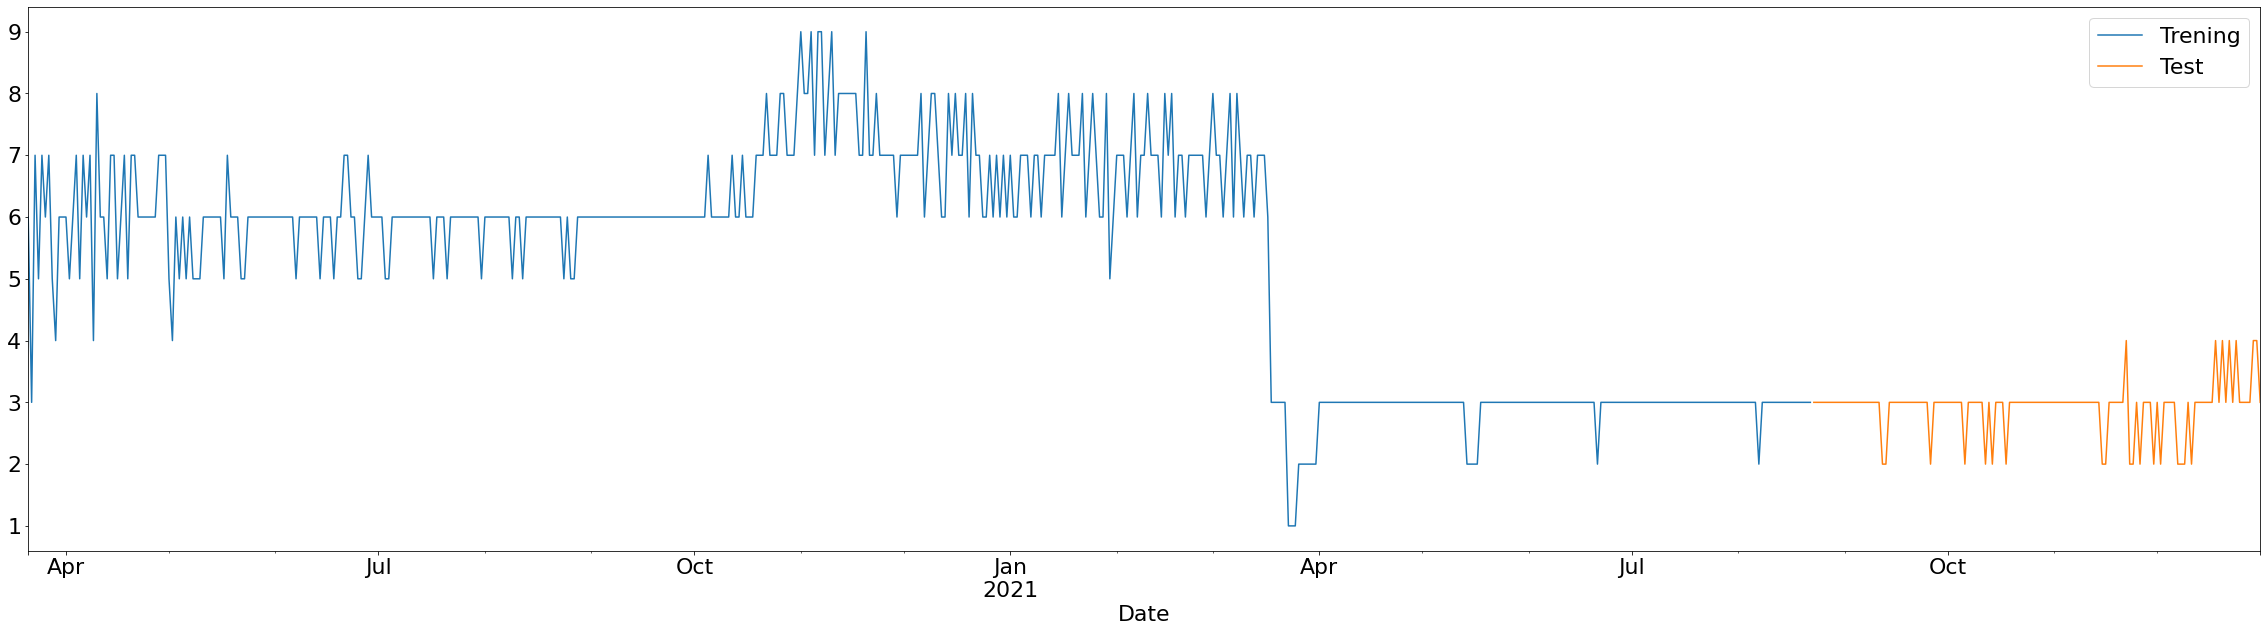

In [14]:
steps = 131  

data_train = data[:-steps]
data_test  = data[-steps:]
plt.rcParams.update({'font.size':22})
fig, ax=plt.subplots(figsize=figsizen)
ax.set_facecolor((1,1,1))
data_train['Readiness'].plot(ax=ax, label='Trening')
data_test['Readiness'].plot(ax=ax, label='Test')
ax.legend();

# Kalkulere moving avarage - rolling lags
### En funksjon som beregner predictors fra time series
### I dette tilfellet blir predictors de første 3 lags og vi setter verdien til moving avarage til siste 20 dager
### lage første 3 lags, og kalkulere moving avarage til de siste 20 vierdiene 

In [24]:
def create_predictors(y):    
    X_train = pd.DataFrame({'y':y.copy()})
    for i in range(0, 3):
        X_train[f'lag_{i+1}'] = X_train['y'].shift(i)
        
    X_train['moving_avg'] = X_train['y'].rolling(20).mean()
    
    X_train = X_train.drop(columns='y').tail(1).to_numpy()  
    
    return X_train  

# Lage og trene Forecaster
#### Vi lager modellen med ForecasterAutoregCustom og så trener vi med Random Forest regressor
#### window_size må være større eller lik med størrelsen vi brukte i funksjonen create_predictors

In [16]:
forecaster = ForecasterAutoregCustom(
                regressor = RandomForestRegressor(random_state=123),
                fun_predictors = create_predictors,
                window_size    = 20
               
             )
forecaster.fit(y=data_train['Readiness'])

# Prediksjon
#### Etter at modellen ble trent, blir test daten prediktet med 20 dager inn i fremtiden

In [17]:
steps = 131
predictions = forecaster.predict(steps=steps)

predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(5)

Date
2021-08-23    3.0
2021-08-24    3.0
2021-08-25    3.0
2021-08-26    3.0
2021-08-27    3.0
Freq: D, Name: pred, dtype: float64

Spiller3


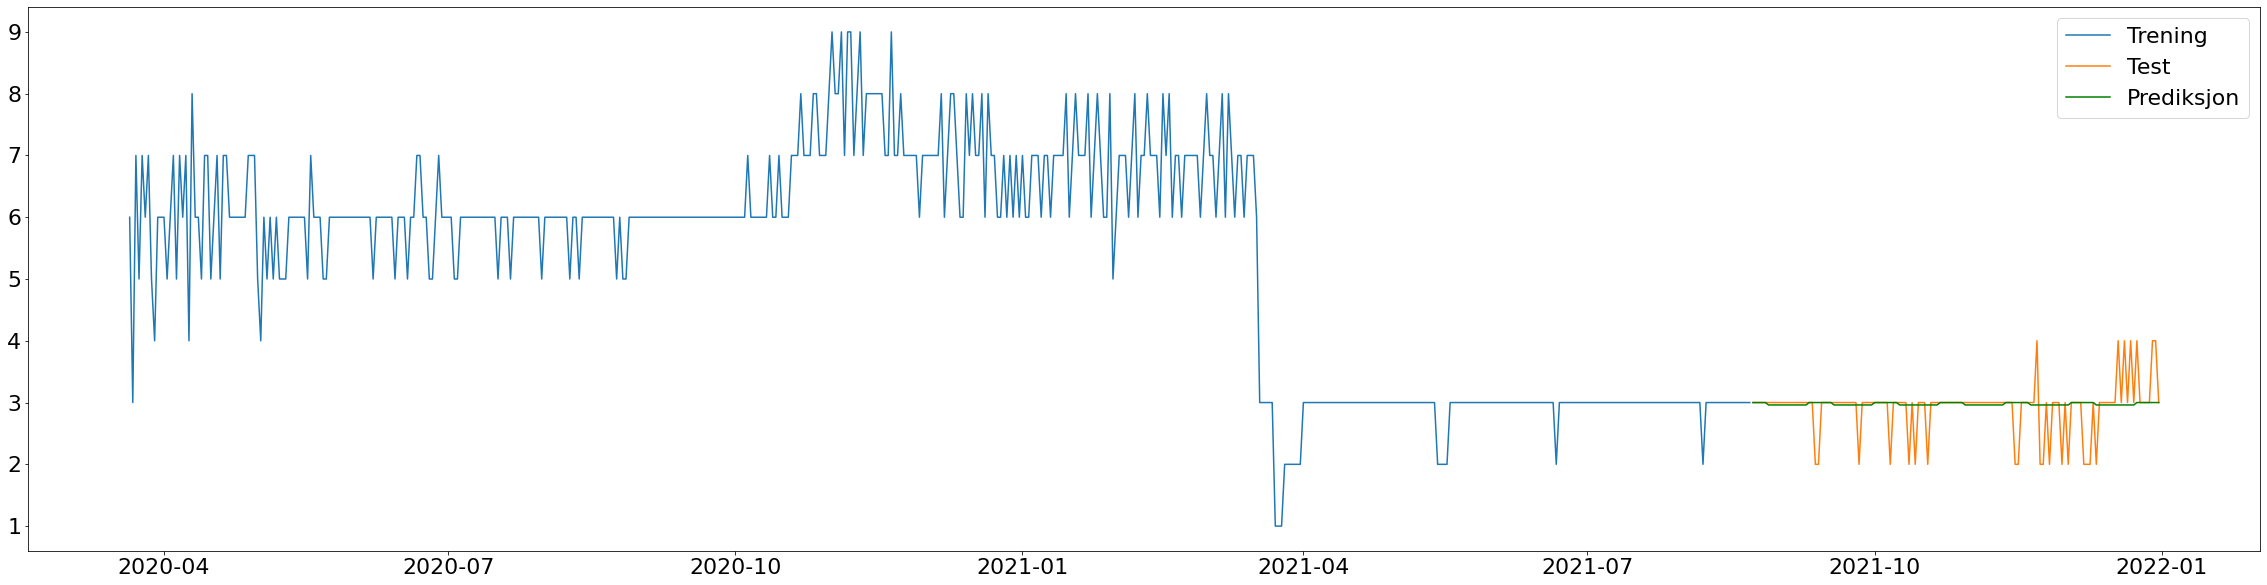

In [18]:
fig, ax = plt.subplots(figsize=figsizen)
plt.plot(data_train['Readiness'],label='Trening')
plt.plot(data_test['Readiness'], label='Test')
plt.plot(predictions, label='Prediksjon', color='green')
plt.rcParams.update({'font.size':22})
ax.set_facecolor((1,1,1))
print("Spiller3")
ax.legend();
plt.show()

# Prediksjon error i testsett
#### Vi benytter oss av MSE og R2 Score test errorne (som i dummy modell) for å se hvor bra modellen presterer

In [19]:
error_mse_prediksjon = mean_squared_error(
                y_true = data_test['Readiness'],
                y_pred = predictions
            )
print(f"MSE test error for prediksjon: {error_mse_prediksjon}")

MSE test error for prediksjon: 0.18816883668717413


In [20]:
error_r2_score_prediksjon = r2_score(
                y_true = data_test['Readiness'],
                y_pred = predictions
            )
print(f"R2 score test error for prediksjon: {error_r2_score_prediksjon}")

R2 score test error for prediksjon: -0.02383177120754465


In [21]:
print(f"MSE test error for prediksjon: {error_mse_prediksjon}")

print(f"R2 score test error for prediksjon: {error_r2_score_prediksjon}")

MSE test error for prediksjon: 0.18816883668717413
R2 score test error for prediksjon: -0.02383177120754465



# Alle test errors

In [23]:
# Alle Errors:

#Dummy 
print("Spiller3:")
print(f"MSE test error for Dummy: {error_mse_dummy}")
print(f"R2 Score test error for Dummy: {error_r2_score_dummy }")

print("--------------------")
print(f"MSE test error for prediksjon: {error_mse_prediksjon}")
print(f"R2 score test error for prediksjon: {error_r2_score_prediksjon}")

Spiller3:
MSE test error for Dummy: 3.505341789376214
R2 Score test error for Dummy: -0.006781095355401057
--------------------
MSE test error for prediksjon: 0.18816883668717413
R2 score test error for prediksjon: -0.02383177120754465


### 